# Data Cleaning with IPUMS USA

## Introduction

This notebook is designed to guide you through a data cleaning workflow using 2017-2022 5-year American Community Survey (ACS) data previously downloaded from the [IPUMS USA](https://cps.ipums.org/usa) project using the [ipumsr R package](https://cran.r-project.org/web/packages/ipumsr/index.htm).

This notebook is designed to be run directly after working through the **IPUMS ACS Data Extraction** notebook.  If you are working on this notebook without previously runnig the **IPUMS ACS Data Extraction** notebook, you will need to copy the "IPUMS_ACS_5y_2022.rds" file into your working directory prior to running this notebook.

Users are also encouraged to revise this notebook for their own purposes and using their own data.

By working through this notebook, you will learn some common workflows for cleanig and recoding population data.

#### Overview
This notebook includes the following sections:

1. Setup
2. Initial Review
3. Cleaning and Recoding Continuous Variables
5. Cleaning and Recoding Categorical Variables
6. Final Review

## 1. Setup

Before running this script, you will need to install and load the following packages into your R environment:

[**dplyr**](https://cran.r-project.org/web/packages/dplyr/index.html) A package for data manipulation that provides a consistent set of functions to filter, arrange, summarize, and transform data. *dplyr* makes it easy to work with data frames and perform operations efficiently.  This notebook uses the the following functions from *dplyr*.
* [*mutate()*](https://dplyr.tidyverse.org/reference/mutate.html) for modifying dataframes
* [*case_when()*](https://dplyr.tidyverse.org/reference/case_when.html) for creating or modifying new dataframe columns based on multiple conditions
* This notebook also uses [*%>%*](https://magrittr.tidyverse.org/reference/pipe.html), referred to as the *pipe* operator, which is used to pass the output from one function directly into the next function for the purpose of creating streamlined workflows.  The *pipe* operator is a commonly used component of the [*tidyverse*](https://www.tidyverse.org).

[**haven**](https://cran.r-project.org/web/packages/haven/index.html) A package primairly designed for importing and exporting SPSS, Stata, and SAS files.  This notebook uses the following functions from *haven*.

* [*as_factor()*](https://haven.tidyverse.org/reference/as_factor.html) for formating categorical variables as factors.

If you are working in the I-GUIDE environment, these packages should be already be installed but you you will still need to load them into your workspace using *library* function.

In [2]:
library(dplyr)
library(haven)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Run the following line of code to read in the "IPUMS_ACS_5y_2022.rds" file.  You may need to update the file path to reflect the file's location on your machine or in your working directory.

In [3]:
dat <- readRDS("IPUMS_ACS_5y_2022.rds")

If you previously ran the **IPUMS USA Data Extraction** notebook, the rest of this section will be redundant.  You can skip to the next section, **2. Initial Review**.

Let's take a look at the number of observations and variables in the data.

In [4]:
dim(dat)

[1] 15721123       20

The 2022 5-year ACS data includes information on 20 variables for 15,721,123 individuals.  This makes sense since we know the ACS surveys about 3.5 million individuals and our dataset corresponds to five years of ACS data.

Let's take a look at the first few lines of the data file.

In [5]:
head(dat)

YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,COUNTYFIP,STRATA,GQ,PERNUM,PERWT,SEX,AGE,RACE,RACED,EDUC,EDUCD,INCTOT
<int>,<dbl>,<int+lbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int+lbl>,<dbl+lbl>,<dbl>,<int+lbl>,<dbl>,<dbl>,<int+lbl>,<int+lbl>,<int+lbl>,<int+lbl>,<int+lbl>,<int+lbl>,<dbl+lbl>
2022,2018,202203,1,2.01801e+12,17,2.022e+12,1,0,160001,4,1,17,2,19,1,100,6,65,-1754
2022,2018,202203,2,2.01801e+12,17,2.022e+12,1,81,190001,4,1,17,2,18,2,200,6,65,1870
2022,2018,202203,3,2.01801e+12,24,2.022e+12,1,0,200001,3,1,24,1,53,1,100,6,64,11691
2022,2018,202203,4,2.01801e+12,8,2.022e+12,1,0,240001,3,1,8,1,28,1,100,7,71,0
2022,2018,202203,5,2.01801e+12,3,2.022e+12,1,97,270101,3,1,3,2,25,1,100,3,30,0
2022,2018,202203,6,2.01801e+12,4,2.022e+12,1,0,240001,3,1,4,2,30,1,100,6,63,0


Notice that this data is in ["tibble"](https://tibble.tidyverse.org) format rather than the more common "data.frame" format you might be used to as an R user.  A tibble can be thought of as a version of a data.frame that includes additional functionality and metadata visibility.  It is also more compatible with the tidyverse packages, including the dplyr package we use in this notebook.

We also appear to have a lot more columns than the set we requested from IPUMS.  The view above truncates the dataset to a subset of the columns for easier viewing.  Let's take a quick look at the list of column names so we can see all the variables included in this dataset.

In [6]:
colnames(dat)

[1] "YEAR"      "MULTYEAR"  "SAMPLE"    "SERIAL"    "CBSERIAL"  "HHWT"     
 [7] "CLUSTER"   "STATEFIP"  "COUNTYFIP" "STRATA"    "GQ"        "PERNUM"   
[13] "PERWT"     "SEX"       "AGE"       "RACE"      "RACED"     "EDUC"     
[19] "EDUCD"     "INCTOT"

The IPUMS R API included both the variables we asked for and some additional variables.

We have the demographic variables we requested:

1. sex (SEX)
2. age (AGE)
3. race (RACE)
4. educational attainment (EDUC)
5. total income (INCTOT)

Along with more descriptive supplementary versions of some of our demographic variables:

6. detailed race (RACED)
7. detailed educational attainment (EDUCD)

And the geographic variables we requested:

8. state FIPS code (STATEFIP)
9. county FIPS code (COUNTYFIP)

IPUMS has also included a set of varibles which we did not specifically request but which are always included in the ACS data downloads:

10. five-year summary reference year (YEAR) (i.e. 2022 for this data)
11. survey year (MULTYEAR) (i.e. 2018, 2019, 2020, 2021, or 2022 for this data)
12. sample identifier (SAMPLE)
13. unique household identifier (SERIAL)
14. Census Bureau unique household identifier (CBSERIAL)
15. household survey weight (HHWT)
16. primmary sampling unit or cluster (CLUSTER)
17. stratification code (STRATA)
18. group quarters code (GQ)
19. person nunber within the household (PERNUM)
20. person weight (PERWT)

## 2. Initial Review

First, let's start with a quick summary using the *summary* command in base R.  We will restrict the summary view to just the subset of demographic variables since those are the variables we will focus on in the data cleaning process for this exercise.

The *summary* command provides a overview of our data and is a quick and easy way of exploring the structure of our data as well as potential issues.

In [7]:
summary(dat[, c("SEX", "AGE", "RACE", "RACED", "EDUC", "EDUCD", "INCTOT")])

      SEX             AGE             RACE           RACED          EDUC       
 Min.   :1.000   Min.   : 0.00   Min.   :1.000   Min.   :100   Min.   : 0.000  
 1st Qu.:1.000   1st Qu.:22.00   1st Qu.:1.000   1st Qu.:100   1st Qu.: 5.000  
 Median :2.000   Median :43.00   Median :1.000   Median :100   Median : 6.000  
 Mean   :1.509   Mean   :42.34   Mean   :2.208   Mean   :224   Mean   : 6.298  
 3rd Qu.:2.000   3rd Qu.:62.00   3rd Qu.:2.000   3rd Qu.:200   3rd Qu.:10.000  
 Max.   :2.000   Max.   :97.00   Max.   :9.000   Max.   :990   Max.   :11.000  
     EDUCD            INCTOT       
 Min.   :  1.00   Min.   : -13093  
 1st Qu.: 50.00   1st Qu.:  12700  
 Median : 65.00   Median :  40210  
 Mean   : 65.43   Mean   :1632244  
 3rd Qu.:101.00   3rd Qu.: 106384  
 Max.   :116.00   Max.   :9999999  

We can see from this summary that all the variables are coded as numeric, even though many of them are categorical, such as "race" or "worker class".  The numeric values for these categorical variables are useless without data labels or a codebook reference.  Fortunately, the IPUMS extraction and download process included metadata for our data, which includes labels for relevant variables.  We can also refer to the [IPUMS website](https://usa.ipums.org/usa-action/variables/group/demog) for detailed information on each variable.  It is a good data stewardship practice to always have the codebook or other reference material nearby while performing the data cleaning process.

The high-level summary also shows us a few potential issues with these data.

1. **All variables are coded as numeric, even though many of them are actually categorical.**  It is very common to code categorical variables using numeric codes but it is important to remember that these categorical variables are useless without data labels or a codebook reference.  Fortunately, the IPUMS extraction and download process included metadata for our data, which includes labels for relevant variables.  We can also refer to the [IPUMS website](https://usa.ipums.org/usa-action/variables/group/demog) for detailed information on each variable.  It is a good data stewardship practice to always have the codebook or other reference material nearby while performing the data cleaning process.
2. **There are no missing values.**  In the summary view of R, these would be indicated by a count of "NA" values for each of the variables.  While it is possible that our data actually has no missing values, it is also very possible that missing values are coded with a specific coding as mentioned in the section above.  Especailly with very large and complex datasets, we should retain a skepticism about the lack of missing values and review each variable and its corresponding labels and codebook during the cleaning process.
3. **The largest total income (INCTOT) value is 9999999.**  While it is possible that this is the actual maximum total income value in the dataset, it is more likely that this is a topcoded reference value.  Often values in multiples of 9s, e.g. "999" or "9999999" indicate a topcoded value, missing, or other special value.  This quick summary overview reminds us that when we clean the INCTOT variable, we should be doubly sure to reference the codebook and data labels.

In the next two sections we will review each of the demographic variables, keeping these potential issues at the front of our mind as we go.

This process will involve looking for and managing and issues with the data, such as missing values or values which need to be recoded, as well as reorganizing variables to make them easier to use or to suit the needs of our project.

## 3. Cleaning and Recoding Categorical Variables

We will start with the three categorical variables in our set demographic variables.  The categorical variables in our dataset include:

* [sex (SEX)](https://usa.ipums.org/usa-action/variables/SEX#codes_section)
* [race (RACE and RACED)](https://usa.ipums.org/usa-action/variables/RACE#codes_section)
* [educational attainment (EDUC and EDUCD)](https://usa.ipums.org/usa-action/variables/EDUC#codes_section)

To help us easily view the percent of the data which is represented by each variable level - as well as the data labels *{{variable}}*, count of observations *n*, and numeric level indicator *Code* - we will create and use following helper function *calculate_percentage*.  Alternately, we could use the base R function *table* which would provide us with the counts for each variable level but would not show the percents or labels.

In [8]:
calculate_percentage <- function(data, variable) {
    data %>%
    count({{variable}}) %>%
    mutate(
        Code = row_number(),
        {{variable}} := as_factor({{variable}}),
        Percent = round(n / sum(n) * 100, 2)
    ) %>%
    select({{variable}}, Code, n, Percent)
}

### 3a. Sex

The [IPUMS codebook for SEX](https://usa.ipums.org/usa-action/variables/SEX#codes_section) shows us that there are three categories for this variable.

1. Male
2. Female
9. Missing/blank

Similar to the INCTOT case we talked about in the inital review, the SEX variable also has a special coding using 9s.  A code of 9 for SEX indicates a missing value.

Let's take a look at the breakdown of the SEX variable in our data.

In [9]:
calculate_percentage(dat, SEX)

SEX,Code,n,Percent
<fct>,<int>,<int>,<dbl>
Male,1,7722475,49.12
Female,2,7998648,50.88


All values in the SEX variable in our data are 1 (male) or 2 (female) and there are no missing values.

### 3b. Race

As we remember from our initial *summary* view, the IPUMS API call included both the RACE variable and a supplementary detailed race RACED variable.  The [IPUMS codebook for RACE and RACED](https://usa.ipums.org/usa-action/variables/RACE#codes_section) shows us that there are nine categories for the basic race variable (RACE) and 253 categories for the detailed race variable (RACED).

Let's first take a look at the RACE variable.

In [10]:
calculate_percentage(dat, RACE)

RACE,Code,n,Percent
<fct>,<int>,<int>,<dbl>
White,1,11191212,71.19
Black/African American,2,1463804,9.31
American Indian or Alaska Native,3,184752,1.18
Chinese,4,228640,1.45
Japanese,5,40156,0.26
Other Asian or Pacific Islander,6,660127,4.20
"Other race, nec",7,754861,4.80
Two major races,8,1099410,6.99
Three or more major races,9,98161,0.62


As we saw in the codebook, the RACE variable has nine categories, and our dataset indcludes individuals in each of the nine categories.

**Note:** The acronym NEC, as in the "Other race, nec" category, stands for "not elsewhere classified" and is commonly used in demographic data.

The RACE variable is an example of a very common occurrance in demographic data where one or a few categories represent the vast the majority of the data and the remaining categories are relatively rare.  In our sample over 70% of the individuals are White!  This sometimes poses an issue in analysis, especially if we are interested in focusing on minority populations.  We won't worry about it much here, but it is something to think about when you conduct your own analyses.

We know that the detailed race variable (RACED) has a lot of categories (253).  Let's check how many of them are represented in our data.

In [11]:
length(unique((dat$RACED)))

[1] 137

The individuals in our data represent 137 of the possible 253 race categories.

137 is still a lot of categories so we aren't going to attempt to view the full table for this variable.  Instead, let's take a look at the first ten categories.

In [12]:
head(calculate_percentage(dat, RACED), 10)

RACED,Code,n,Percent
<fct>,<int>,<int>,<dbl>
White,1,11191212,71.19
Black/African American,2,1463804,9.31
Apache,3,3784,0.02
Blackfoot,4,1563,0.01
Cherokee,5,15772,0.10
Chickasaw,6,1665,0.01
Chippewa,7,6531,0.04
Choctaw,8,5925,0.04
Creek,9,2715,0.02


We can already see that this version of the race variable has a lot of additional information.  The first two categories (White and Black/African-American) are the same as the RACE variable but the next few categories split up the more general "American Indian or Alaska Native" cateogry and specify specific Native American tribes.  Without looking at the entire list of all categories in RACED we can get an idea of the level of detail included in this variable.

This level of detail might come in handy later on if we use this data for a detailed race-based analysis.  But for now let's keep it simple and stick to just using the RACE variable.

#### Recoding the Race Variable

Even the 9 race categories in the simple RACE variable is a lot, and if we are plannign to run a regression or do some other analysis where statistical power is important, we might want to simplify this variable even further.

Depending on the type of analysis you conduct, it might be essential to reduce the number of cateogies - especially condensing categories with very few observations - so that you can run an analysis with sufficient statisitcal power.  When it comes to a variable like race, the practice of combining categories can be contentious and nuanced.  For this exercise, we will condense our data to five very commonly used race categories for working with data on the United States general population.  These are the categories currently in use for the U.S. Decennial Census.

1. White
2. Black or African-American
3. American Indian or Alaska native
4. Asian or Pacific Islander
5. Some Other Race
6. Two or More Races

This process will condense our data down from 9 to 6 categories.  Individuals classified as "4. Chinese", "5. Japanese", "6, Other Asian or Pacific Islander" will be reclassified to the new "4. Asian or Pacific Islander" category and indiviuals classified as "8. Two major races" and "9. Three or more major races" will be reclassified the new "6. Two or More Races" category.

We will use the *mutate()* and *case_when()* functions from the *dplyr* package to create a new variable (RACE_RECODE) based on information from the existing RACE variable.

In [13]:
dat <- dat %>%
  mutate(RACE_RECODE = case_when(
    RACE == 1 ~ 1,
    RACE == 2 ~ 2,
    RACE == 3 ~ 3,
    RACE %in% c(4, 5, 6) ~ 4,
    RACE == 7 ~ 5,
    RACE %in% c(8, 9) ~ 6))

We should also specify the new RACE_RECODE variable as a [**factor**](https://r4ds.hadley.nz/factors.html) which a data type used to represent categorical variables that have a limited and fixed set of possible categories.  The individual categories of a factor are usually referred to as "levels".  A nice feature of factors is that we can also set the order of the levels and add labels to each level.

The RACE_RECODE only has five possible levels, corresponding to the five race groupings we created, so it fits the critera of a factor.    We will add labels in this step which will help us remembewhat races are grouped into the categories represented by r each of t RACE_RECODE levels.e.

In [14]:
dat <- dat %>%
  mutate(RACE_RECODE = factor(RACE_RECODE,
                              levels = c(1, 2, 3, 4, 5, 6),
                              labels = c("White",
                                         "Black",
                                         "American Indian or Native American",
                                         "Asian or Pacific Islander",
                                         "Other Race",
                                         "Two or More Races")))

Let's take a look at the new variable.

In [15]:
calculate_percentage(dat, RACE_RECODE)

RACE_RECODE,Code,n,Percent
<fct>,<int>,<int>,<dbl>
White,1,11191212,71.19
Black,2,1463804,9.31
American Indian or Native American,3,184752,1.18
Asian or Pacific Islander,4,928923,5.91
Other Race,5,754861,4.80
Two or More Races,6,1197571,7.62


We now have a new, simplified version of the RACE variable with fewer categories.  The smallest group (American Indian or Native American) corresponds to 1.18% of the population while the largest group (White) corresponds to 71.19% of the population.

### 3c. Education

Similar to the RACE variable, the eductional attainment variable EDUC also has a supplementary, more detailed educational attainment variable EDUCD.  The EDUC and EDUCD variables provide information on total individual educational attainment.  The [IPUMS codebook for EDUC and EDUCD](https://usa.ipums.org/usa-action/variables/EDUCD#codes_section) shows us that there are 13 categories for the basic education variable (EDUC) and 44 categories for the detailed education variable (EDUCD).

Let's first take a look at the EDUC variable.

In [16]:
calculate_percentage(dat, EDUC)

EDUC,Code,n,Percent
<fct>,<int>,<int>,<dbl>
N/A or no schooling,1,931255,5.92
Nursery school to grade 4,2,1117203,7.11
"Grade 5, 6, 7, or 8",3,993865,6.32
Grade 9,4,319559,2.03
Grade 10,5,351462,2.24
Grade 11,6,395440,2.52
Grade 12,7,4658839,29.63
1 year of college,8,1799557,11.45
2 years of college,9,1059890,6.74


Taking a look at the EDUC variable, we can see that the first level corresponds to either "N/A" or "no schooling".  At the beginning of the EDA section, we mentioned the possibility of some variables having levels which correspond to missing or not applicable values.  Unfortunatly for us, the two components of the "N/A or no schooling" group correspond to two very different situations.  Most likely, we would want to seperate these two situations, recoding the "N/A" values as "missing" and either creating a seperate group for individuals with no schooling or combining them into a "little or no schooling" category.

We can also see that, while the EDUC variable provides information on the number of years of education completed, it does not provide information on degree completion.  In most cases, there is a significant social and economic difference between actually receiving a high school diploma and completing 12 years of education but not receiving a high school diploma.  It would be best if we could explore additional detail for the individuals in some of these categories.

Fortunatly, we have the EDUCD variable which has a lot more information on educational attainment.  Let's take a look at what information is available in EDUCD.

In [17]:
calculate_percentage(dat, EDUCD)

EDUCD,Code,n,Percent
<fct>,<int>,<int>,<dbl>
N/A,1,437349,2.78
No schooling completed,2,493906,3.14
"Nursery school, preschool",3,209748,1.33
Kindergarten,4,180016,1.15
Grade 1,5,166978,1.06
Grade 2,6,177927,1.13
Grade 3,7,192714,1.23
Grade 4,8,189820,1.21
Grade 5,9,205537,1.31


The EDUCD variable has many more categories including seperate categories for "N/A" and "no schooling completed" as well as detailed information on degree completion!

#### Recoding the Education Variable

Like with the RACE variable in the previous section, we are going to recode the education variable into a new set of groups which might be a bit more useful for analysis.  This time we will use information from the EDUCD variable since it contains the additional detail we need to be able to make groups for "N/A", "no schooling", and completion of specific degrees.

Our recode will have the following seven categories.

1. eight or fewer years of eduction (including no schooling)
2. some high school (9-12 years, no degree)
3. high school diploma, GED, or alternative credential completed
4. some college (1+ years, no degree)
5. associate's degree
6. bachelor's degree
7. advanced degree (master's, professional, or doctoral degree)

This new variable will include missing values since we plan to recode instances of "N/A" to missing.  In R, missing values are represented by the special object *NA*.  Most analytical functions in R automatically ignore *NA* values or have an option to ignore them so recoding missing categories as *NA* will make things easier for us down the line.

In [18]:
dat <- dat %>%
  mutate(EDUC_RECODE = case_when(
    EDUCD == 1 ~ NA,                # N/A
    EDUCD %in% c(2:26) ~ 1,         # eight or fewer years (including no schooling)
    EDUCD %in% c(30:61) ~ 2,        # some high school (9-12 years, no degree)
    EDUCD %in% c(63:64) ~ 3,        # high school diploma, GED, or alternative credential completed
    EDUCD %in% c(65:71) ~ 4,        # some college (1+ years, no degree)
    EDUCD == 81 ~ 5,                # associate's degree
    EDUCD == 101 ~ 6,               # bachelor's degree
    EDUCD %in% c(114:116) ~ 7))     # advanced degree (master's, professional, or doctoral degree)

As with the RACE_RECODE variable in the previous section, we will classify the EDUC_RECODE as a factor and attach category labels.

In [19]:
dat <- dat %>%
  mutate(EDUC_RECODE = factor(EDUC_RECODE,
                              levels = c(1, 2, 3, 4, 5, 6, 7),
                              labels = c("eight or fewer years",
                                         "some high school, no degree",
                                         "high school degree or equivalent",
                                         "some college, no degree",
                                         "associate's degree",
                                         "bachelor's degree",
                                         "advanced degree")))

Let's take a look at the new variable.

In [20]:
calculate_percentage(dat, EDUC_RECODE)

EDUC_RECODE,Code,n,Percent
<fct>,<int>,<int>,<dbl>
eight or fewer years,1,2604974,16.57
"some high school, no degree",2,1327250,8.44
high school degree or equivalent,3,3473697,22.10
"some college, no degree",4,2723910,17.33
associate's degree,5,1059890,6.74
bachelor's degree,6,2492914,15.86
advanced degree,7,1601139,10.18
NA,8,437349,2.78


Again we have a new, simplified version of the a categorical variable with fewer categories.  In this case, the new variable is both simplier than either of the original RACE and RACED variables and also reorganizes the data in a way which is more meaningful for the analyses we have in mind.

## 4. Cleaning and Recoding Continuious Variables

Now that we have finished reviewing the three categorical demographic varables, we will move on to the two continuous demographic variables.  The continuous variables in our dataset include:

* [age (AGE)](https://usa.ipums.org/usa-action/variables/AGE#codes_section)
* [individual total income (INCTOT)](https://usa.ipums.org/usa-action/variables/INCTOT#codes_section)

### 4a. Age

The AGE variable provides the numeric age, in years, for each indiviual in the sample.  Checking out the [IPUMS codebook for AGE](https://usa.ipums.org/usa-action/variables/AGE#codes_section) tells us that there is a missing value code corresponding to "999" but based on our initial review of the data, we don't appear to have any "999" codes and therefore no missing data for age.  We will double check for missing values in this step.

We could use the *calculate_percentage* function we had been using for the categorical variables to view the AGE variable but that would give us a table for every age in the dataset, probably not very useful.

Instead, let's take a look at the summary statistics using the *summary()* command from base R and distribution for this numeric variable using the historgam *hist()* command also from base R.

Both functions are from base R!  The information and graphics they will provide are relatively simple and not very pretty but the commands are also simple and easy to remember, part of the base R environment (so they don't require any additional packages), and computationally non-intensive.  You could use more complicated functions to generate summary tables and visualizations but at this stage, when we just want quick snapshots of the data so we can make management decisions, the simple base R functions work great.

In [21]:
summary(dat$AGE)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   22.00   43.00   42.34   62.00   97.00 

Ages in this sample range from 0 to 97 which seems reasonable.  And we also can confirm that we don't have any instances of the "999" code indicating missing data.

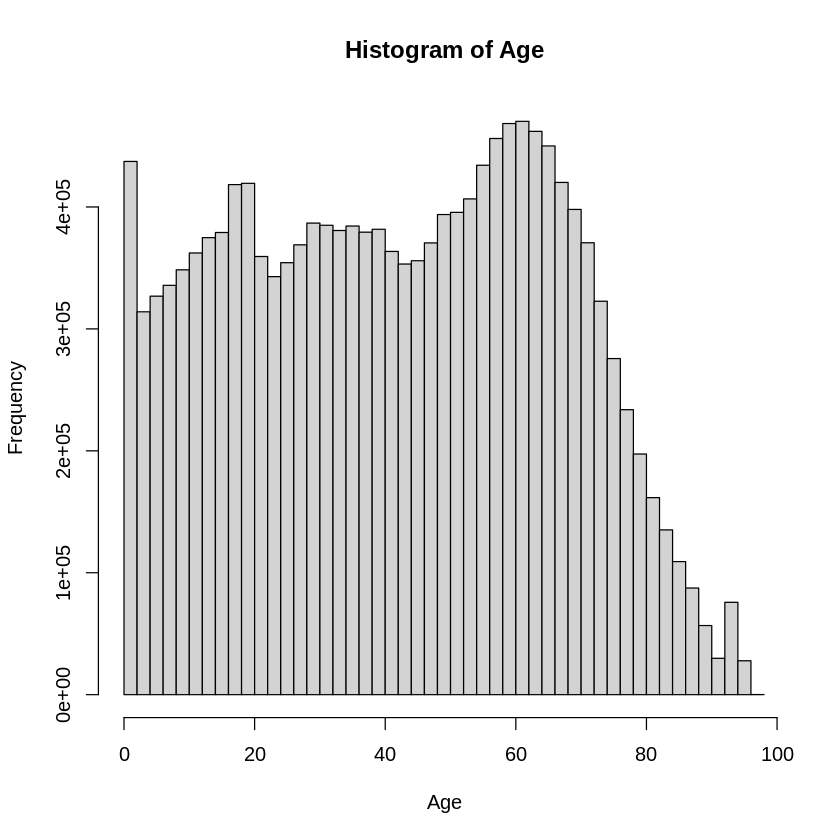

In [22]:
hist(dat$AGE, breaks = 50, main = "Histogram of Age", xlab = "Age")

The distribution of ages, as shown in the histogram, also seems to be a reasonable representation of a random sample of the population.

While the numeric AGE variable is very useful, it likely contains more detail that we will need for our analysis.  So let's create a new categorical age variable based on age ranges.  Our new variable will use the following commonly used age ranges for demographic and sociological research.

1. 0 to 17 (children)
2. 18 to 24 (young adults)
3. 25 to 44
4. 45 to 64
5. 65+ (older adults; retirement age)

We will use the *mutate()* function from the *dplyr* package to recode information from AGE variable into a new AGE_CAT variable.

In [23]:
dat <- dat %>%
  mutate(AGE_CAT = case_when(
    AGE < 18 ~ 1,
    AGE %in% c(18:24) ~ 2,
    AGE %in% c(25:44) ~ 3,
    AGE %in% c(45:64) ~ 4,
    AGE >= 65 ~ 5))

Although the original AGE variable was continuous, the new AGE_CAT variable is categorical and like RACE_RECODE and EDUC_RECODE, AGE_CAT is also a factor.  Therefore, we will specify AGE_CAT as a factor and set labels for each variable level using the same workflow we used for the cateogorical variables.

In [17]:
dat <- dat %>%
  mutate(AGE_CAT = factor(AGE_CAT,
                              levels = c(1, 2, 3, 4, 5),
                              labels = c("under 18",
                                         "18-24",
                                         "25-44",
                                         "45-64",
                                         "65+")))

Now that we have a labeled, categorical version of the AGE variable, let's take a look at the percent breakdown by age range.

In [18]:
calculate_percentage(dat, AGE_CAT)

AGE_CAT,Code,n,Percent
<fct>,<int>,<int>,<dbl>
under 18,1,3070679,19.53
18-24,2,1347750,8.57
25-44,3,3737684,23.77
45-64,4,4213399,26.80
65+,5,3351611,21.32


The new AGE_CAT variable simplifies the AGE information into a format which is likely easier for us to use and understand.

### 4b. Income

The last demographic varaible we will work with is the income variable (INCTOT).  Like the age variable, the original version of this variable is numeric and specifes the exact income for each surveyed individual.  We can take a look at the 

As with AGE, rather than using the *calculate_percentage* function, we'll use the base R *summary()* function to check out the summary statistics for the variable, and the base R *hist()* function to view the distribution of income.

In [24]:
summary(dat$INCTOT)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -13093   12700   40210 1632244  106384 9999999 

The "9999999" maximum value should raise some alarm and remind you that we previously noticed the maximum INCTOT value is "9999999".  Something to be suspicious about...

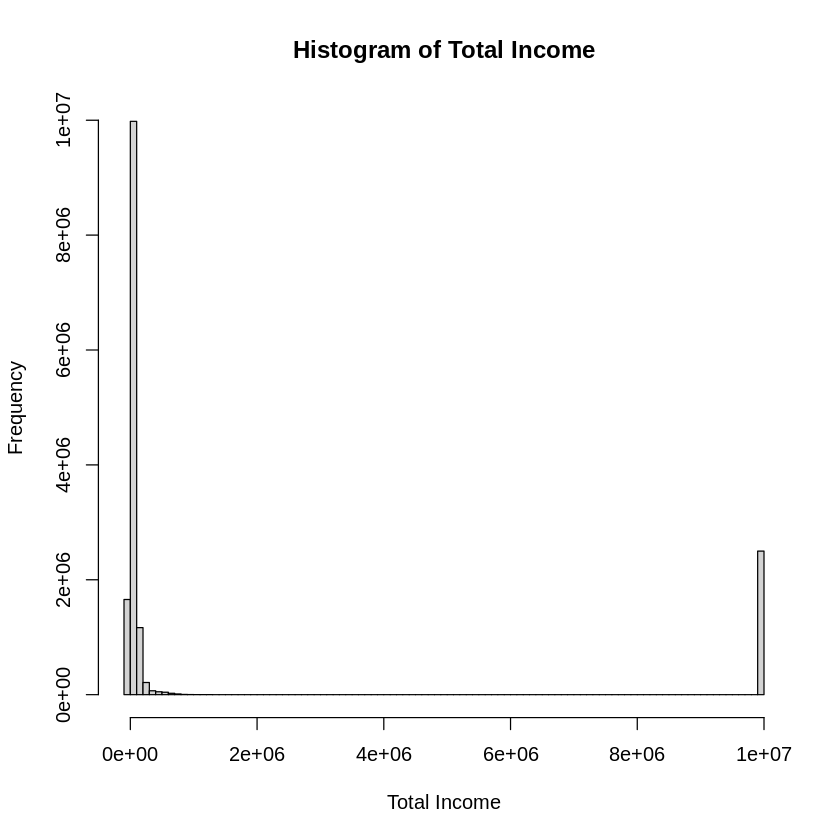

In [25]:
hist(dat$INCTOT, breaks = 100, main = "Histogram of Total Income", xlab = "Total Income")

The histogram showing the distribution of income values is another red flag that something is not right.  Numeric, continuous demographic variables almost always follow some type of normal or log-normal distribution.  However, there is clearly a large chunk of the data categorized at a very high value.  An anomaly which doesn't seem to follow the pattern of the rest of the data.

The solution is to take a look at the [IPUMS codebook for INCTOT](https://usa.ipums.org/usa-action/variables/INCTOT#codes_section).  The codebooks tells us that value "9999998" indicates "unknown" and the value "9999999" indictes "N/A".

So for our next step we should recode these two values as *NA* so they won't be included in any calculations or in while visualizing the distribution.

In [28]:
dat <- dat %>%
  mutate(INCTOT = na_if(INCTOT, 9999998),
         INCTOT = na_if(INCTOT, 9999999))

Let's take another look at the summary statistics and the distribution of values after recoding the missing information.

In [29]:
summary(dat$INCTOT)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -13093    9875   30000   50384   63152 1870446 2499455 

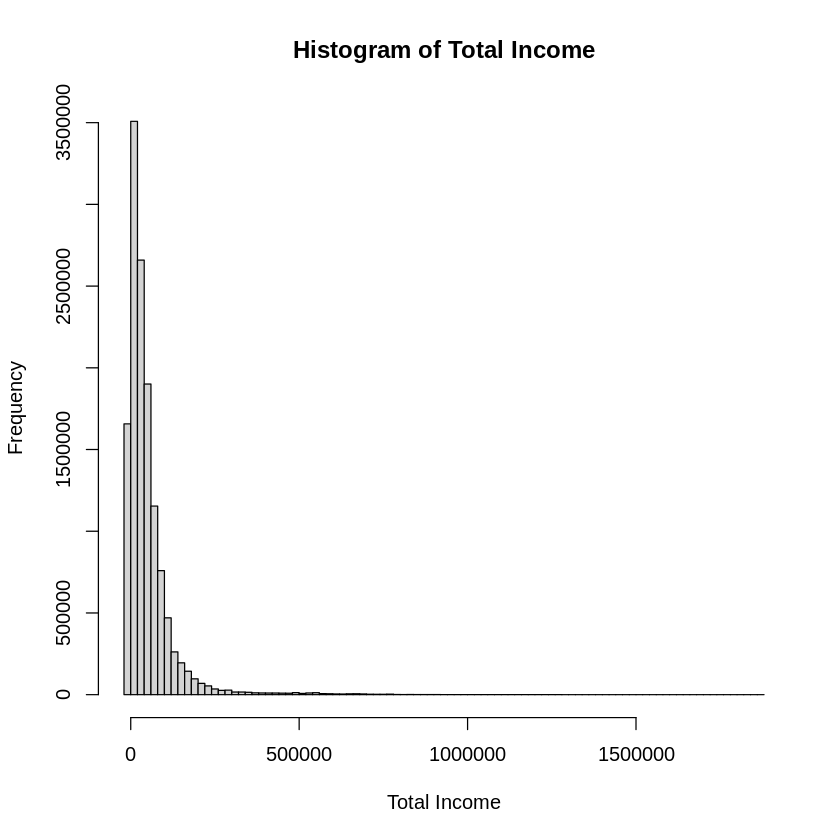

In [30]:
hist(dat$INCTOT, breaks = 100, main = "Histogram of Total Income", xlab = "Total Income")

After the recode the data summary and distribution appear much more as we would expect.  The distribution shows that the majority of the individuals in the sample have incomes around 200,000 or less but there are a few outliers ranging up to the largest income in the sample, 1.87 million.

Similar to age, total income is not very useful as a raw number.  Instead, it's often more useful to look at income brackets rather than raw income values.

A recode would be especially useful in our situation since we have an income distribution with a very long right tail, indicating that we have a few individuals with very high incomes who are skewing the overall distribution.  When we have a highly skewed dataset, values usually take on wildly different meanings at different parts of the distribution.  For example, the difference between an income of 10,000 and 50,000 corresponds to a very large difference in lifestyle and socioeconmic status.  However, the difference between an income of 1,010,000 and 1,050,000 is likely negligible, both very high incomes correspond to a similair lifestyle and very high socioeconomic status.

We will recode the income variable in the following way:

1. < 25,000 (low income)
2. 25,000 to 49,999 (lower-middle income)
3. 50,000 to 74,999 (middle income)
4. 75,000 to 149,999 (upper-middle income)
5. 150,000 or more (high income)

In [32]:
dat <- dat %>%
  mutate(INCTOT_CAT = case_when(
    INCTOT < 25000 ~ 1,
    INCTOT %in% c(25000:49999) ~ 2,
    INCTOT %in% c(50000:74999) ~ 3,
    INCTOT %in% c(75000:149999) ~ 4,
    INCTOT >= 150000 ~ 5))

As usuall, we will code this variable as a factor and create a set of labels for each level.

In [33]:
dat <- dat %>%
  mutate(INCTOT_CAT = factor(INCTOT_CAT,
                              levels = c(1, 2, 3, 4, 5),
                              labels = c("under 25,000",
                                         "25,000 to 49,999",
                                         "50,000 to 74,999",
                                         "75,000 to 149,999",
                                         "150,000 or more")))

Let's take a look at the percentage breakdown for our new categorical variable.

In [34]:
calculate_percentage(dat, INCTOT_CAT)

INCTOT_CAT,Code,n,Percent
<fct>,<int>,<int>,<dbl>
"under 25,000",1,5881976,37.41
"25,000 to 49,999",2,2935713,18.67
"50,000 to 74,999",3,1798438,11.44
"75,000 to 149,999",4,1829175,11.64
"150,000 or more",5,747065,4.75
NA,6,2528756,16.09


As with AGE_CAT, the INCTOT_CAT variable simplifies the income information into a simplier format which is easier to understand and work with.

## 5. Final Review

We've completed initial data management and recode steps for each of the demographic variables we requested in our abstract.  Let's take a final look at the updated summary information including all the new demographic varaibles we created in this section.

In [35]:
summary(dat[, c("SEX", "AGE", "AGE_CAT", "RACE", "RACED", "RACE_RECODE", "EDUC", "EDUCD", "EDUC_RECODE", "INCTOT", "INCTOT_CAT")])

      SEX             AGE           AGE_CAT           RACE           RACED    
 Min.   :1.000   Min.   : 0.00   Min.   :1.000   Min.   :1.000   Min.   :100  
 1st Qu.:1.000   1st Qu.:22.00   1st Qu.:2.000   1st Qu.:1.000   1st Qu.:100  
 Median :2.000   Median :43.00   Median :3.000   Median :1.000   Median :100  
 Mean   :1.509   Mean   :42.34   Mean   :3.218   Mean   :2.208   Mean   :224  
 3rd Qu.:2.000   3rd Qu.:62.00   3rd Qu.:4.000   3rd Qu.:2.000   3rd Qu.:200  
 Max.   :2.000   Max.   :97.00   Max.   :5.000   Max.   :9.000   Max.   :990  
                                                                              
                             RACE_RECODE            EDUC       
 White                             :11191212   Min.   : 0.000  
 Black                             : 1463804   1st Qu.: 5.000  
 American Indian or Native American:  184752   Median : 6.000  
 Asian or Pacific Islander         :  928923   Mean   : 6.298  
 Other Race                        :  754861   3

We've made a lot of updates!  We now have categorical versions of our two continuous numeric variables, AGE and INCTOT, and new, recoded versions of RACE and EDUC.  We've also recoded the missing values in EDUC_RECODE and INC_TOT to *NA* so we can use these variables in analyses without having to worry about incorrectly treating the missing codes like real numers.

Let's make a simplified version of the data, specifically for analysis, that only includes the variables we plan to keep.

This step isn't essential but it will give us a smaller version of the data to work with in the next steps of our analysis which will be less confusing and less computationally intensive to work with.

Specifically, we will restrict our data to the following demographic variables:

1. sex (SEX)
2. age (AGE)
3. age categories (AGE_CAT)
4. race categories (RACE_RECODE)
5. educational attainment categories (EDUC_RECODE)
6. income (INCTOT)
7. income categories (INCTOT_CAT)

And the two geographic identification variables we included in our original data extraction:

6. state FIPS code (STATEFIP)
7. county FIPS code (COUNTYFIP)

In [40]:
dat_analysis <- dat %>% select(STATEFIP, COUNTYFIP, SEX, AGE, AGE_CAT, RACE_RECODE, EDUC_RECODE, INCTOT, INCTOT_CAT)

Let's take a look at the first few lines of *dat_analysis*.

In [41]:
head(dat_analysis)

STATEFIP,COUNTYFIP,SEX,AGE,AGE_CAT,RACE_RECODE,EDUC_RECODE,INCTOT,INCTOT_CAT
<int+lbl>,<dbl+lbl>,<int+lbl>,<int+lbl>,<dbl>,<fct>,<fct>,<dbl+lbl>,<fct>
1,0,2,19,2,White,"some college, no degree",-1754,"under 25,000"
1,81,2,18,2,Black,"some college, no degree",1870,"under 25,000"
1,0,1,53,4,White,high school degree or equivalent,11691,"under 25,000"
1,0,1,28,3,White,"some college, no degree",0,"under 25,000"
1,97,2,25,3,White,"some high school, no degree",0,"under 25,000"
1,0,2,30,3,White,high school degree or equivalent,0,"under 25,000"


And a look at the summary information for *dat_analysis*.

In [38]:
summary(dat_analysis)

    STATEFIP       COUNTYFIP           SEX           AGE_CAT     
 Min.   : 1.00   Min.   :  0.00   Min.   :1.000   Min.   :1.000  
 1st Qu.:12.00   1st Qu.:  0.00   1st Qu.:1.000   1st Qu.:2.000  
 Median :27.00   Median : 19.00   Median :2.000   Median :3.000  
 Mean   :27.76   Mean   : 50.75   Mean   :1.509   Mean   :3.218  
 3rd Qu.:42.00   3rd Qu.: 73.00   3rd Qu.:2.000   3rd Qu.:4.000  
 Max.   :56.00   Max.   :810.00   Max.   :2.000   Max.   :5.000  
                                                                 
                             RACE_RECODE      
 White                             :11191212  
 Black                             : 1463804  
 American Indian or Native American:  184752  
 Asian or Pacific Islander         :  928923  
 Other Race                        :  754861  
 Two or More Races                 : 1197571  
                                              
                           EDUC_RECODE                  INCTOT_CAT     
 high school degree or e

We'll save a copy of *dat_analysis* in the .rds file format using the *saveRDS* base R function.  The .rds format will allow us to retain the labels and metadata in our dataset for the next time we want to import the same file back into R.  One downside to the .rds format is it is only useable within R.

Alternatively we could save this file as a .csv or other common format which would allow us to easily open it in other settings.  However, for this exercise, we are simply interested in storing a copy of our data so that we can use it in another notebook withouth having to go through the data cleaning and labeling steps again.

In [42]:
saveRDS(dat_analysis, "dat_analysis.rds")

We now have a cleaned, quality dataset saved and ready for our next step, exploratory data analysis (EDA)!

## Next Steps

From here, we recommend exploring the following notebooks:

* **Exploratory Data Analysis (EDA) with IPUMS USA**